In [1]:
from matplotlib import pyplot as plt
from matplotlib import pylab #displays arrays as images for easy error checking
import numpy as np
import scipy as sp
import networkx as nx
from PIL import Image
from PIL import ImageDraw
%matplotlib inline

In [2]:
# Functions for equivalent resistance calculation

def G_matrix(graph):
    """
    Using the data from the input networkx graph, returns
    the G matrix needed to complete the nodal analysis calculation.
    """
    # Find the reciprocal of resistance for each connection (i.e. each edge)
    for node1, node2 in graph.edges():
        graph[node1][node2]['reciprocalR'] = 1.0 / graph[node1][node2]['resistance']
    # The adjacency matrix gives all needed elements but the diagonal
    G = nx.adjacency_matrix(graph, weight='reciprocalR')
    # Add the diagonal
    G.setdiag(np.squeeze(np.asarray(-nx.incidence_matrix(graph, weight='reciprocalR').sum(axis=1))))
    # G is a csr_matrix, but we want an array
    return G.toarray()

def equivalent_resistance(graph, check_nodes):
    """
    Given a graph and a list of two check nodes,
    computes the equivalent resistance.
    """

    # Get the G matrix
    G = G_matrix(graph)
    I = np.zeros(len(G))
    I[check_nodes[0]] = 1.
    I[check_nodes[1]] = -1.
    
    # Solve for the voltage matrix
    try:
        V = np.linalg.solve(G, I)
        
        # use a simple numpy operation to compute the equivalent resistance
        equivalent_resistance = abs(sum(I*V))
        return equivalent_resistance
    except:
        # if np.linalg.solve fails, raise an error
        print("Error: could not solve the matrix equation. Is the G-matrix singular?")
        raise

In [3]:
# credit to Bryce Boe http://bryceboe.com/2006/10/23/line-segment-intersection-algorithm/

def ccw(ax, ay, bx, by, cx, cy):
    """
    Determines whether points a, b, and c are counerclockwise
    """
    return (cy - ay)*(bx - ax) > (by-ay)*(cx-ax)

def intersect(ax, ay, bx, by, cx, cy, dx, dy):
    """
    a and b describe one line segment; c and d describe another.
    """
    return (ccw(ax, ay, cx, cy, dx, dy) != ccw(bx, by, cx, cy, dx, dy) and
            ccw(ax, ay, bx, by, cx, cy) != ccw(ax, ay, bx, by, dx, dy))

In [4]:
def draw_network(network_size, CNT_endpoints, contiguous_nodes):
    """
    Outputs a drawing of the CNT network of given size
    whose endpoints are listed in CNT_endpoints.
    """
    
    #size of image
    image_size = (network_size, network_size) #pixels
    #initializing a blank image
    image = Image.new('RGBA', image_size, (255,255,255,255))
    #selecting the image in which to draw and creating the drawing interface
    draw = ImageDraw.Draw(image)
    #setting the color for each line as black
    black = (0, 0, 0, 255) 
    red = (255, 0, 0, 255)

    #drawing the individual line segment on the image
    for tube in CNT_endpoints:
        draw.line(((tube[0],tube[1]),(tube[2],tube[3])), fill=black, width=1)
        
    for i, tube in enumerate(CNT_endpoints):
        if i+2 in contiguous_nodes: #add 2 to index because CNT_endpoints doesn't contain tubes 0 and 1
            draw.line(((tube[0],tube[1]),(tube[2],tube[3])), fill=red, width=1)

    #dislplaying the image
    plt.imshow(np.asarray(image), origin='lower')
    plt.show()
    image.save('CNT_network.png')

In [5]:
#Important variables
network_size = 10 #side length of network boundaries
CNT_length_normal = 445 #normal length of CNT at center of distribution
CNT_length_stddev = 310 #standard deviation of CNT length from normal
CNT_num_tubes = 1000 #number of tubes in film
resistance_mean = 10
resistance_stddev = 1

def model(network_size,
         CNT_length_normal,
         CNT_length_stddev,
         CNT_num_tubes,
         resistance_mean,
         resistance_stddev):
    """
    Returns the equivalent resistance, given inputs of the size of the CNT film,
    and information about the tubes' size distribution.
    """
    CNT_init = np.zeros((CNT_num_tubes+2,7))

    #creating the pseudo tubes that will act as the edges in the network
    CNT_init[0:2,:] = [[network_size,0,0,0,0,network_size,0],
                       [network_size,0,1,0,network_size,network_size,network_size]]
    
    #Generating tube information
    #randomly assigning tube lengths distributed around a set tube length
    logmean = np.log(CNT_length_normal / (np.sqrt(1+(CNT_length_stddev/CNT_length_normal)**2)))
    logstdev = np.sqrt(np.log(1+(CNT_length_stddev/CNT_length_normal)**2))
    CNT_init[2:,0] = np.random.lognormal(logmean, logstdev, CNT_num_tubes)

    #randomly assign starting point and orientation
    CNT_init[2:,1:4] = np.random.rand(CNT_num_tubes, 3)

    #applying scaling to random numbers so they match the needed values
    scaling_factor = np.array([1, network_size, network_size, 2*np.pi, 1, 1, 1])
    CNT_init = CNT_init * scaling_factor

    #calculating the x-max for the tubes
    CNT_init[:,5] = CNT_init[:,1] + np.cos(CNT_init[:,3]) * CNT_init[:,0]

    #calculating the y-max for the tubes
    CNT_init[:,6] = CNT_init[:,2] + np.sin(CNT_init[:,3]) * CNT_init[:,0]

    #calculating slope
    CNT_init[:,3] = np.tan(CNT_init[:,3])
    
    #calculating the y-intercept of the lines
    CNT_init[:,4] = CNT_init[:,2] - CNT_init[:,3] * CNT_init[:,2]

    #generating a boolean array of the tubes that intersect
    CNT_intersect = np.zeros((CNT_num_tubes+2,CNT_num_tubes+2),dtype=bool)
    
    for i,row1 in enumerate(CNT_init):
        for j,row2 in enumerate(CNT_init[i+1:,:]):
            coords = np.concatenate((row1[1:3], row1[5:7], row2[1:3], row2[5:7]))
            if intersect(*coords):
                CNT_intersect[i,j+i+1] = True
    
    #gives the indicies along the x-axis of the true values as the 
    #first array and the y-values as the second array
    CNT_tube_num1, CNT_tube_num2 = np.where(CNT_intersect)
    
    #add the intersections as edges in a networkx graph
    graph = nx.Graph()
    graph.add_edges_from((CNT_tube_num1[k], CNT_tube_num2[k],
                          {'resistance': np.random.normal(resistance_mean, resistance_stddev)})
                         for k in range(0, np.sum(CNT_intersect)))
    
    #get rid of any bits of the graph not contiguous with node 0 (one of the test nodes)
    #thanks to Pieter Swart from 2006 [https://groups.google.com/forum/#!topic/networkx-discuss/XmP5wZhrDMI]
    contiguous_nodes = nx.node_connected_component(graph, 0)
    new_graph = graph.subgraph(contiguous_nodes)
    
    #draw the network:
    #generating the endpoints for the tubes in the network
    CNT_endpoints = np.zeros((CNT_num_tubes,4))
    CNT_endpoints[:,0:2] = CNT_init[2:,1:3]
    CNT_endpoints[:,2:4] = CNT_init[2:,5:7]
    #call the drawing function
    draw_network(network_size, CNT_endpoints, contiguous_nodes)
    
    #draw the networkx graph
    nx.draw(new_graph, with_labels=True, font_weight='bold', node_size=100, font_size=9)
    
    #computes equiv. resistance
    if nx.has_path(new_graph, 0, 1):
        try:
            eqr = equivalent_resistance(new_graph,[0,1])
        except:
            eqr = np.nan
    else:
        print("Could not compute equivalent resistance; there is no contiguous path through the network.")
        eqr = np.nan
 
    return eqr

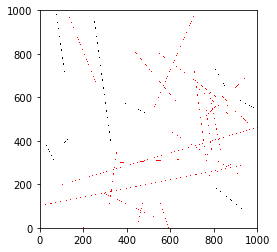

Equivalent resistance: 6.639653081855966 ohm/sq


/Users/mplajer/anaconda/lib/python3.6/site-packages/scipy/sparse/compressed.py:774: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


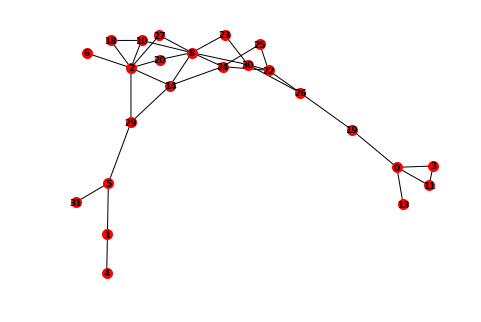

In [6]:
np.random.seed(42)
print("Equivalent resistance: {} ohm/sq"
      .format(model(1000, CNT_length_normal, CNT_length_stddev, 30, 10, 1)))